# Bitcoin Fraud Management System using Machine Learning and Deep Learning techniques

## Importing all the libraries

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix,classification_report
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
LABELS = ["Normal", "Fraud"]
print('check')

check


In [2]:
df = pd.read_csv('C:/Users/Devanshi/Desktop/BE Project/Bitcoin dataset/DG_out.csv', sep=',')
df.head()

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,0,1,0.0,50.0,50.0,0.0,50.0,0,0,0,0,0
1,f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...,1,2,50.0,50.0,100.0,50.0,25.0,0,0,0,0,0
2,ea44e97271691990157559d0bdd9959e02790c34db6c00...,1,1,10.0,10.0,20.0,10.0,10.0,0,0,0,0,0
3,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,1,1,40.0,30.0,70.0,40.0,30.0,0,0,0,0,0
4,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,1,2,30.0,30.0,60.0,30.0,15.0,0,0,0,0,0


In [3]:
df.shape

(30248134, 13)

In [4]:
columns = df.columns.tolist()
columns = [c for c in columns if c not in ["out_and_tx_malicious","tx_hash"]]
target='out_and_tx_malicious'
X = df[columns]
Y = df['out_and_tx_malicious']
print(X.shape)
print(Y.shape)

(30248134, 11)
(30248134,)


In [5]:
Y.value_counts()

0    30248026
1         108
Name: out_and_tx_malicious, dtype: int64

## Splitting the dataset

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size = 0.27, random_state=10)

In [7]:
X_train.shape,y_train.shape

((22081137, 11), (22081137,))

In [8]:
X_test.shape,y_test.shape

((8166997, 11), (8166997,))

In [9]:
y_train.value_counts()

0    22081059
1          78
Name: out_and_tx_malicious, dtype: int64

In [10]:
y_test.value_counts()

0    8166967
1         30
Name: out_and_tx_malicious, dtype: int64

## Feature Selection

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
'''
#Method 1
sel_f = SelectKBest(f_classif, k=10)
X_train_f = sel_f.fit(X_train, y_train)
print(sel_f.get_support())
'''
bestfeatures = SelectKBest(score_func=f_classif, k=8)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))  #print 8 best features

            Specs         Score
8   out_malicious  3.730937e+07
9    is_malicious  1.619278e+07
10  all_malicious  1.981881e+06
7    in_malicious  1.296211e+03
2          in_btc  3.792878e+02
4       total_btc  3.596737e+02
3         out_btc  3.392067e+02
6    mean_out_btc  3.256418e+02


In [12]:
columns=['in_malicious','out_malicious','is_malicious','all_malicious','in_btc','out_btc','mean_out_btc','mean_in_btc','total_btc']
X_train=X_train[columns]
X_test=X_test[columns]

## Downsampling the data

In [13]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.0002)
X_train1, y_train1= rus.fit_sample(X_train,y_train)

In [14]:
X_train1.shape,y_train1.shape

((390078, 9), (390078,))

In [15]:
y_train1.value_counts()

0    390000
1        78
Name: out_and_tx_malicious, dtype: int64

## Oversampling the data

In [16]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(sampling_strategy=0.05)
X_train_res, y_train_res = os.fit_sample(X_train1, y_train1)

In [17]:
#drop mean_in_btc from X_train and X_test
mean_in_train=X_train_res['mean_in_btc']
mean_in_test=X_test['mean_in_btc']
X_train_res.drop('mean_in_btc',axis=1,inplace=True)
X_test.drop('mean_in_btc',axis=1,inplace=True)
X_train.drop('mean_in_btc',axis=1,inplace=True)

In [18]:
X_train_res.shape,y_train_res.shape

((409500, 8), (409500,))

In [19]:
y_train_res.value_counts()

0    390000
1     19500
Name: out_and_tx_malicious, dtype: int64

In [20]:
print('Original training dataset shape',X_train.shape,y_train.shape)
print('Undersampled and then Oversampled training dataset shape',X_train_res.shape,y_train_res.shape)
print('Test dataset shape',X_test.shape,y_test.shape)

Original training dataset shape (22081137, 8) (22081137,)
Undersampled and then Oversampled training dataset shape (409500, 8) (409500,)
Test dataset shape (8166997, 8) (8166997,)


In [21]:
print('original y_train value_counts \n',y_train.value_counts())
print('\nundersampled and then oversampled y_train value_count \n',y_train_res.value_counts())
print('\ny_test value_counts \n',y_test.value_counts())

original y_train value_counts 
 0    22081059
1          78
Name: out_and_tx_malicious, dtype: int64

undersampled and then oversampled y_train value_count 
 0    390000
1     19500
Name: out_and_tx_malicious, dtype: int64

y_test value_counts 
 0    8166967
1         30
Name: out_and_tx_malicious, dtype: int64


In [22]:
data1=X_train_res.copy()
data1[target]=y_train_res

In [23]:
data1.shape

(409500, 9)

In [24]:
precision=[]
recall=[]
f1=[]
accuracy=[]

In [25]:
original_fraud=len(df[df[target]==1])
original_normal=len(df[df[target]==0])
df1=pd.DataFrame(y_test)
test_fraud=len(df1[df1[target]==1])
test_normal=len(df1[df1[target]==0])

fraud = data1[data1[target]==1]
normal = data1[data1[target]==0]
outlier_fraction = len(fraud)/float((len(fraud)+len(normal)))

In [26]:
print('Original dataset Fraudulent %d and Normal %d'% (original_fraud,original_normal))
print('Undersampled and then Oversampled training dataset Fraudulent %d and Normal %d'% (len(fraud),len(normal)))
print('Test dataset Fraudulent %d and Normal %d'%(test_fraud,test_normal))

Original dataset Fraudulent 108 and Normal 30248026
Undersampled and then Oversampled training dataset Fraudulent 19500 and Normal 390000
Test dataset Fraudulent 30 and Normal 8166967


In [27]:
print('Percentage of fraudulent transactions in total original dataset {:.5f} %'.format((original_fraud/(original_fraud+original_normal))*100))
print('Percentage of fraudulent transactions in undersampled and then oversampled dataset + y_test {:.3f} %'.format(((len(fraud)+test_fraud)/(len(fraud)+len(normal)+test_fraud+test_normal))*100))


Percentage of fraudulent transactions in total original dataset 0.00036 %
Percentage of fraudulent transactions in undersampled and then oversampled dataset + y_test 0.228 %


## Plot

<IPython.core.display.Javascript object>


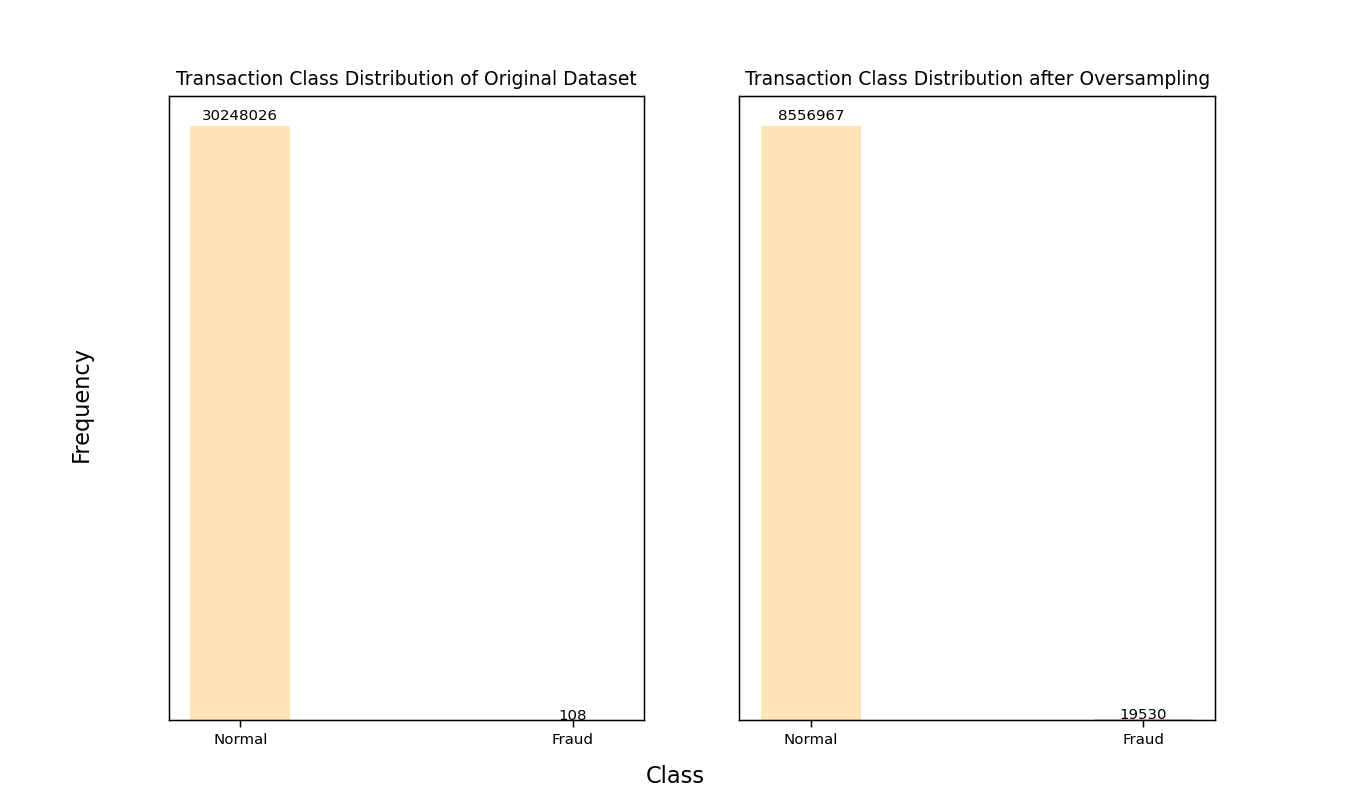

Text(0.06, 0.5, 'Frequency')

In [28]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
plt.subplots_adjust(wspace=0.2)

count_classes = [original_normal,original_fraud]
ax[0].set_xticks(range(2))
ax[0].bar(range(2),count_classes,color=['moccasin','pink'],width=0.3)
ax[0].set_xticklabels(LABELS,fontsize=8)
ax[0].set_yticks([])
ax[0].set_title("Transaction Class Distribution of Original Dataset",fontsize=10)
for i,v in enumerate(count_classes):
    ax[0].text(i,v*1.01,str(v),color='black',fontsize=8, ha='center')

    
count_classes=[len(normal)+test_normal, len(fraud)+test_fraud]
ax[1].bar(range(2),count_classes,color=['moccasin','pink'],width=0.3)
ax[1].set_xticks(range(2))
ax[1].set_xticklabels(LABELS,fontsize=8)
ax[1].set_yticks([])
ax[1].set_title("Transaction Class Distribution after Oversampling",fontsize=10)
for i,v in enumerate(count_classes):
    ax[1].text(i,v*1.01,str(v),color='black',fontsize=8, ha='center')
    
    

# Set common labels
fig.text(0.5, 0.04, 'Class', ha='center', va='center',fontsize=12)
fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical',fontsize=12)








## Confusion Matrix

In [29]:
def conf_matrix_percent(c,l):
    plt.figure(figsize=(5,5))
    sns.heatmap(c, annot=True,fmt='.0f',cmap='Blues',xticklabels=LABELS, yticklabels=LABELS,annot_kws={"size": 9})
    #Confusion Matrix Visual
    plt.title("{} Confusion Matrix".format(l))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

## Support Vector Machine 

In [30]:
svm= LinearSVC(C=4,random_state=42, dual=False)
clf = CalibratedClassifierCV(svm) 
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)
print("Support Vector Machine Algorithm")
print("Accuracy Score :")
a1=accuracy_score(y_test,y_pred)
print(a1)
print("Classification Report :")
print(classification_report(y_test,y_pred))
c1=classification_report(y_test,y_pred, output_dict=True)

print("tn --> true negatives")
print("fp --> false positives")
print("fn --> false negatives")
print("tp --> true positives")
c=confusion_matrix(y_test,y_pred)
tn,fp,fn,tp=c.ravel()
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)

precision.append(round(c1['macro avg']['precision'],2))
recall.append(round(c1['macro avg']['recall'],2))
f1.append(round(c1['macro avg']['f1-score'],2))
accuracy.append(a1)

Support Vector Machine Algorithm
Accuracy Score :
0.9999572670346273
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   8166967
           1       0.08      1.00      0.15        30

    accuracy                           1.00   8166997
   macro avg       0.54      1.00      0.57   8166997
weighted avg       1.00      1.00      1.00   8166997

tn --> true negatives
fp --> false positives
fn --> false negatives
tp --> true positives
Confusion Matrix
tn = 8166618 fp = 349
fn = 0 tp = 30


<IPython.core.display.Javascript object>


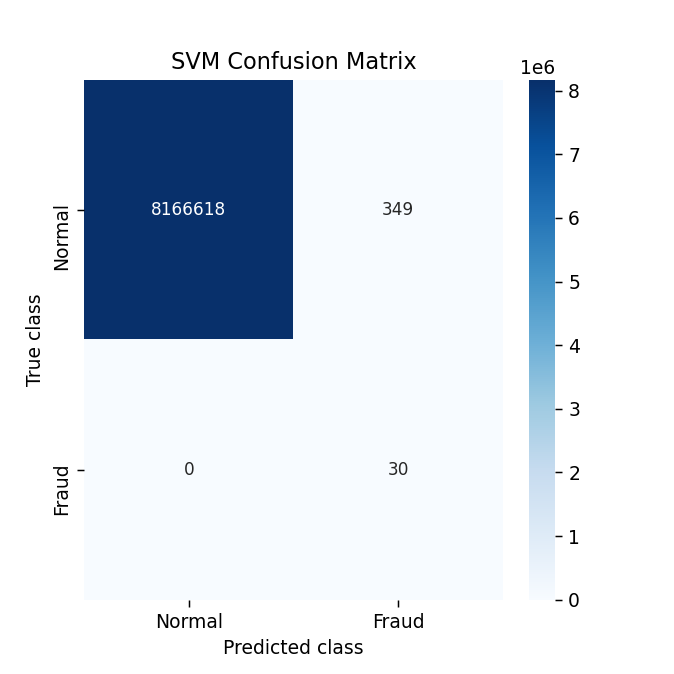

In [31]:
conf_matrix_percent(c,"SVM")

## Isolation Forest Algorithm

Isolation Forest Algorithm
Accuracy Score :
0.9938900430598909
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   8166967
           1       0.00      0.93      0.00        30

    accuracy                           0.99   8166997
   macro avg       0.50      0.96      0.50   8166997
weighted avg       1.00      0.99      1.00   8166997

tn --> true negatives
fp --> false positives
fn --> false negatives
tp --> true positives
Confusion Matrix
tn = 8117069 fp = 49898
fn = 2 tp = 28


<IPython.core.display.Javascript object>


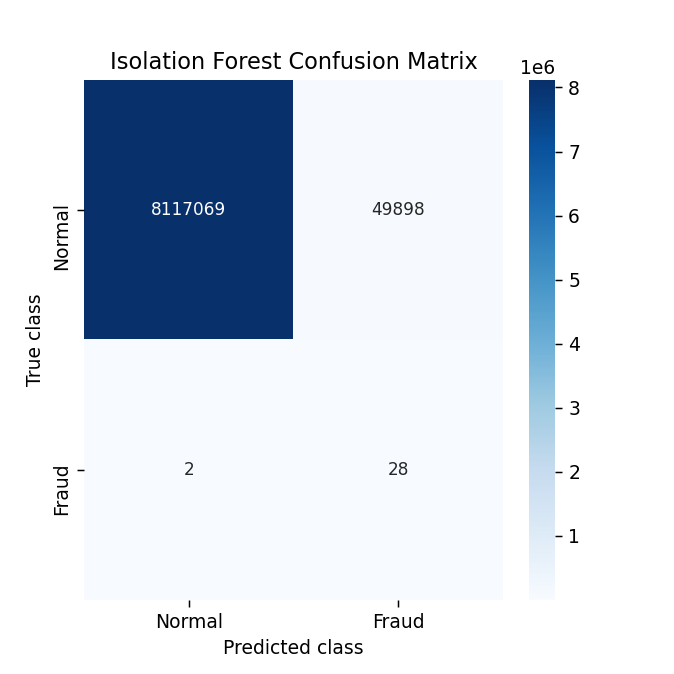

In [32]:
clf=IsolationForest(max_samples=len(X_train_res), contamination=outlier_fraction,random_state=42)
clf.fit(X_train_res)
y_pred = clf.predict(X_test)
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
# Run Classification Metrics
print("Isolation Forest Algorithm")
print("Accuracy Score :")
a2= accuracy_score(y_test,y_pred)
print(a2)
print("Classification Report :")
print(classification_report(y_test,y_pred))
c2=classification_report(y_test,y_pred, output_dict=True)

print("tn --> true negatives")
print("fp --> false positives")
print("fn --> false negatives")
print("tp --> true positives")
c=confusion_matrix(y_test,y_pred)
tn,fp,fn,tp=c.ravel()
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)

precision.append(round(c2['macro avg']['precision'],2))
recall.append(round(c2['macro avg']['recall'],2))
f1.append(round(c2['macro avg']['f1-score'],2))
accuracy.append(a2)
conf_matrix_percent(c,"Isolation Forest")


## Local Outlier Factor Algorithm

Local Outlier Factor Algorithm
Accuracy Score :
0.9686302076516007
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   8166967
           1       0.00      0.60      0.00        30

    accuracy                           0.97   8166997
   macro avg       0.50      0.78      0.49   8166997
weighted avg       1.00      0.97      0.98   8166997

tn --> true negatives
fp --> false positives
fn --> false negatives
tp --> true positives
Confusion Matrix
tn = 7910782 fp = 256185
fn = 12 tp = 18


<IPython.core.display.Javascript object>


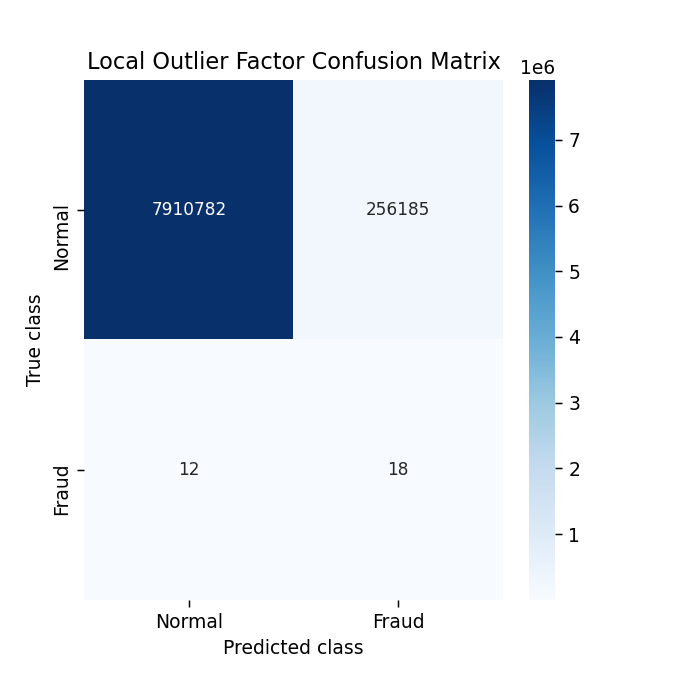

In [33]:
clf=LocalOutlierFactor(n_neighbors=20, contamination=0.03, novelty=True)
clf.fit(X_train_res)
y_pred=clf.predict(X_test) 
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
# Run Classification Metrics
print("Local Outlier Factor Algorithm")
print("Accuracy Score :")
a3= accuracy_score(y_test,y_pred)
print(a3)
print("Classification Report :")
print(classification_report(y_test,y_pred))
c3=classification_report(y_test,y_pred, output_dict=True)

print("tn --> true negatives")
print("fp --> false positives")
print("fn --> false negatives")
print("tp --> true positives")
c=confusion_matrix(y_test,y_pred)
tn,fp,fn,tp=c.ravel()
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)

precision.append(round(c3['macro avg']['precision'],2))
recall.append(round(c3['macro avg']['recall'],2))
f1.append(round(c3['macro avg']['f1-score'],2))
accuracy.append(a3)
conf_matrix_percent(c,"Local Outlier Factor")

## Neural Networks using MLP

In [34]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train_res, y_train_res.values.ravel())
predictions = mlp.predict(X_test)
print("Neural Networks Algorithm")
print("Accuracy Score :")
a4=accuracy_score(y_test,predictions)
print(a4)
print("Classification Report :")
print(classification_report(y_test,predictions))
c4=classification_report(y_test,predictions,output_dict=True)

print("tn --> true negatives")
print("fp --> false positives")
print("fn --> false negatives")
print("tp --> true positives")
c=confusion_matrix(y_test,predictions)
tn,fp,fn,tp=c.ravel()
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)

precision.append(round(c4['macro avg']['precision'],2))
recall.append(round(c4['macro avg']['recall'],2))
f1.append(round(c4['macro avg']['f1-score'],2))
accuracy.append(a4)

Neural Networks Algorithm
Accuracy Score :
0.9996347494678889
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   8166967
           1       0.01      1.00      0.02        30

    accuracy                           1.00   8166997
   macro avg       0.50      1.00      0.51   8166997
weighted avg       1.00      1.00      1.00   8166997

tn --> true negatives
fp --> false positives
fn --> false negatives
tp --> true positives
Confusion Matrix
tn = 8163984 fp = 2983
fn = 0 tp = 30


<IPython.core.display.Javascript object>


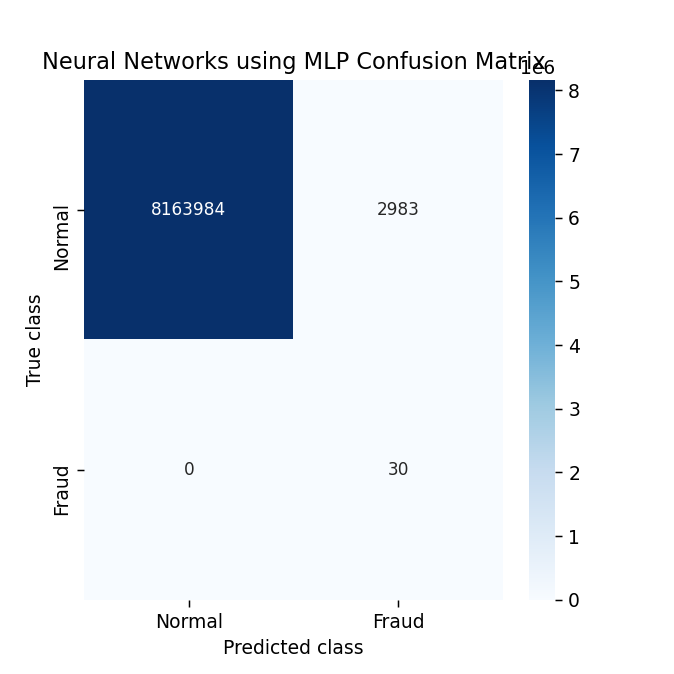

In [35]:
conf_matrix_percent(c,"Neural Networks using MLP")

## K-Means 

K-Means Algorithm
Accuracy Score :
0.9992178275564445
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   8166967
           1       0.00      0.03      0.00        30

    accuracy                           1.00   8166997
   macro avg       0.50      0.52      0.50   8166997
weighted avg       1.00      1.00      1.00   8166997

tn --> true negatives
fp --> false positives
fn --> false negatives
tp --> true positives
Confusion Matrix
tn = 8160608 fp = 6359
fn = 29 tp = 1


<IPython.core.display.Javascript object>


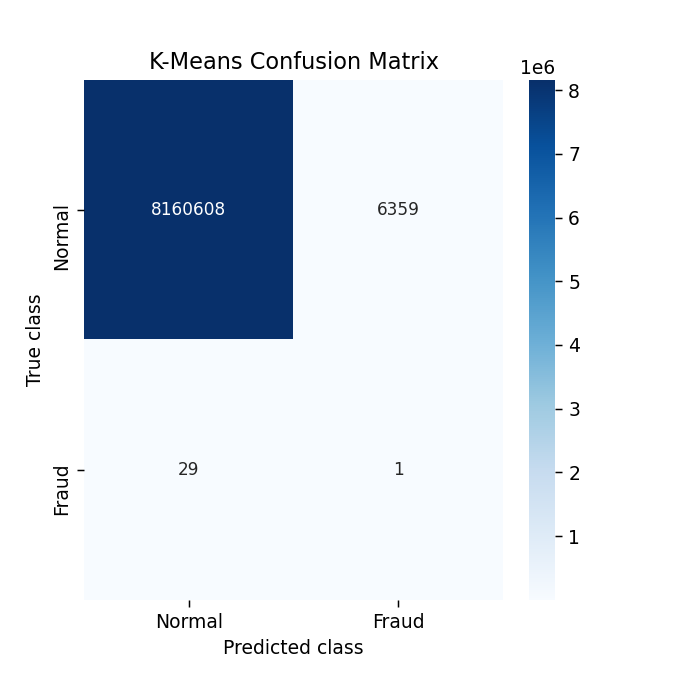

In [36]:
kmeans=KMeans(n_clusters=2,random_state=42,max_iter=10000)
kmeans.fit(X_train_res)
kmeans_y_pred=kmeans.predict(X_test)
print("K-Means Algorithm")
print("Accuracy Score :")
a5=accuracy_score(y_test,kmeans_y_pred)
print(a5)
print("Classification Report :")
print(classification_report(y_test,kmeans_y_pred))
c5=classification_report(y_test,kmeans_y_pred,output_dict=True)

print("tn --> true negatives")
print("fp --> false positives")
print("fn --> false negatives")
print("tp --> true positives")
c=confusion_matrix(y_test,kmeans_y_pred)
tn,fp,fn,tp=c.ravel()
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)

precision.append(round(c5['macro avg']['precision'],2))
recall.append(round(c5['macro avg']['recall'],2))
f1.append(round(c5['macro avg']['f1-score'],2))
accuracy.append(a5)
conf_matrix_percent(c,"K-Means")


<IPython.core.display.Javascript object>


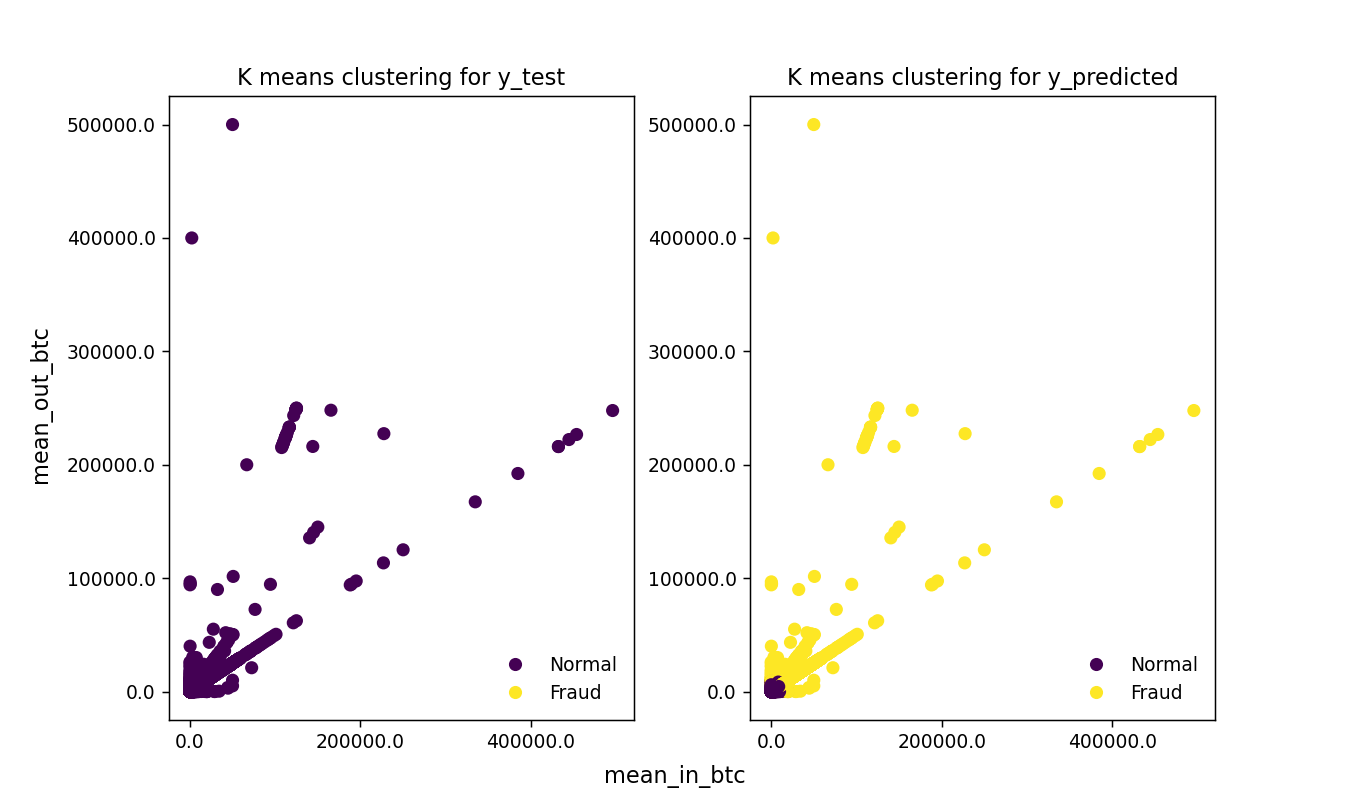

Text(0.03, 0.5, 'mean_out_btc')

In [38]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
fig, ax = plt.subplots(1,2, figsize=(10,6))
plt.subplots_adjust(wspace=0.25)
s=ax[0].scatter(mean_in_test,X_test['mean_out_btc'],c=y_test)
ax[0].set_xticklabels(ax[0].get_xticks(),fontsize=10)
ax[0].set_yticklabels(ax[0].get_yticks(),fontsize=10)
ax[0].set_title("K means clustering for y_test", size=12)
handles, labels = s.legend_elements(prop="colors")
ax[0].legend(handles, ['Normal','Fraud'], loc="lower right",fontsize=10,frameon=False)

w=ax[1].scatter(mean_in_test,X_test['mean_out_btc'],c=kmeans_y_pred)
ax[1].set_xticklabels(ax[1].get_xticks(),fontsize=10)
ax[1].set_yticklabels(ax[1].get_yticks(),fontsize=10)
ax[1].set_title("K means clustering for y_predicted", size=12)
handles, labels = w.legend_elements(prop="colors")
ax[1].legend(handles, ['Normal','Fraud'], loc="lower right",fontsize=10,frameon=False)


# Set common labels
fig.text(0.5, 0.04, 'mean_in_btc', ha='center', va='center',fontsize=12)
fig.text(0.03, 0.5, 'mean_out_btc', ha='center', va='center', rotation='vertical',fontsize=12)

## K Nearest Neighbors 

In [44]:
k=[5,25,50,100]
train=[]
test=[]
for i in k:
    knn=KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree",n_jobs=-1)
    knn.fit(X_train_res,y_train_res.ravel())
    train_score = knn.score(X_train_res,y_train_res)
    test_score  = knn.score(X_test, y_test)
    train.append(train_score)
    test.append(test_score)
    print('done for',i)


done for 5
done for 25
done for 50
done for 100


<IPython.core.display.Javascript object>


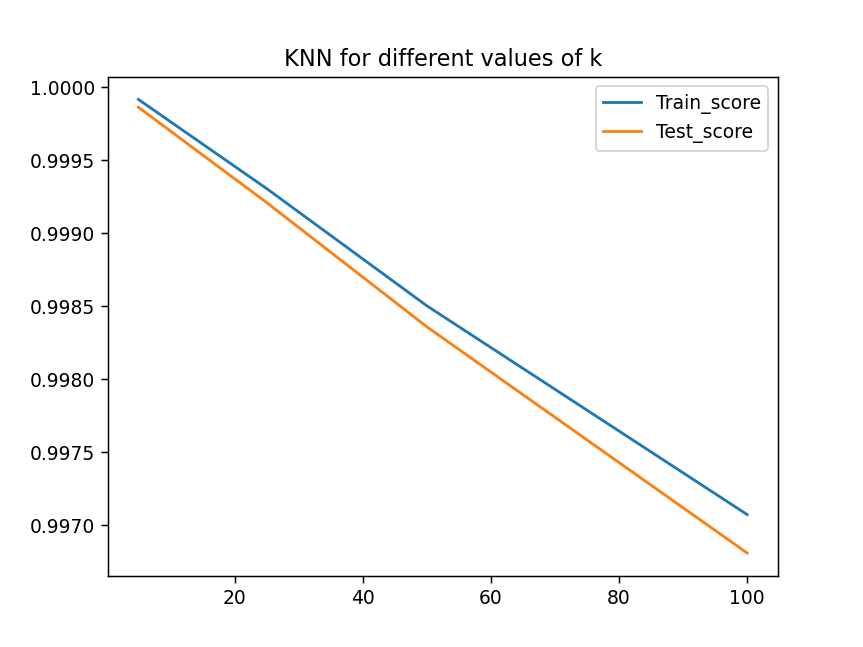

In [45]:
plt.figure()
plt.plot(k,train,label='Train_score')
plt.plot(k,test,label='Test_score')
plt.title('KNN for different values of k')
plt.legend()
d=pd.DataFrame()
d['k']=k
d['train']=train
d['test']=test


In [46]:
print(d)

     k     train      test
0    5  0.999917  0.999863
1   25  0.999306  0.999211
2   50  0.998503  0.998359
3  100  0.997072  0.996808


In [42]:
d_f=pd.DataFrame(mean_in_train.to_numpy(),X_train_res['mean_out_btc'].to_numpy())
d_f.reset_index(inplace=True)

<IPython.core.display.Javascript object>


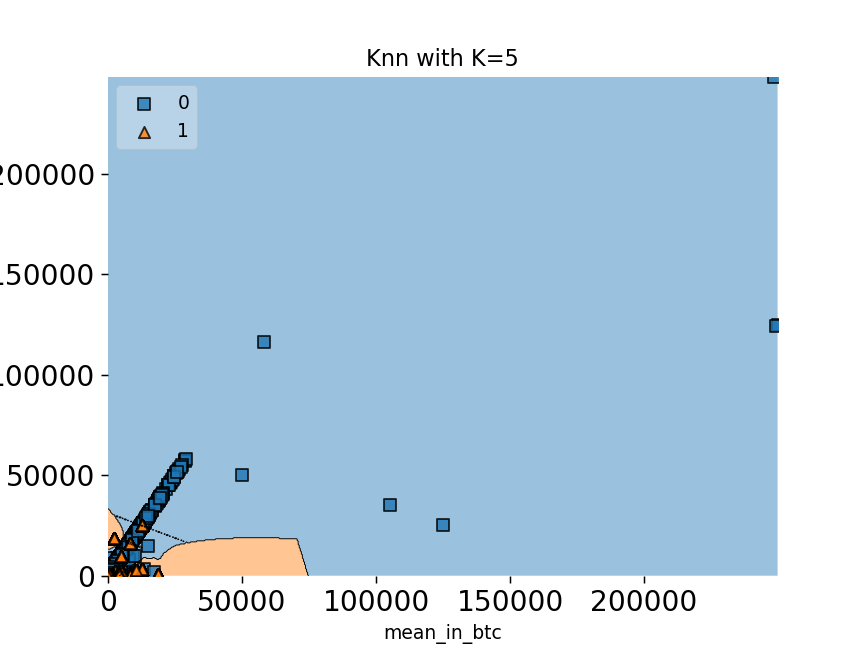

<IPython.core.display.Javascript object>


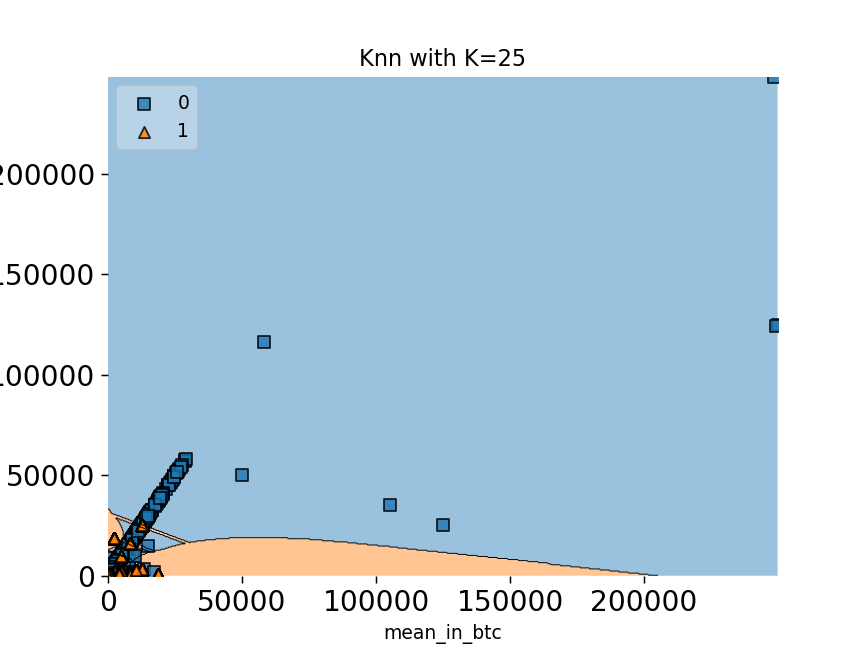

<IPython.core.display.Javascript object>


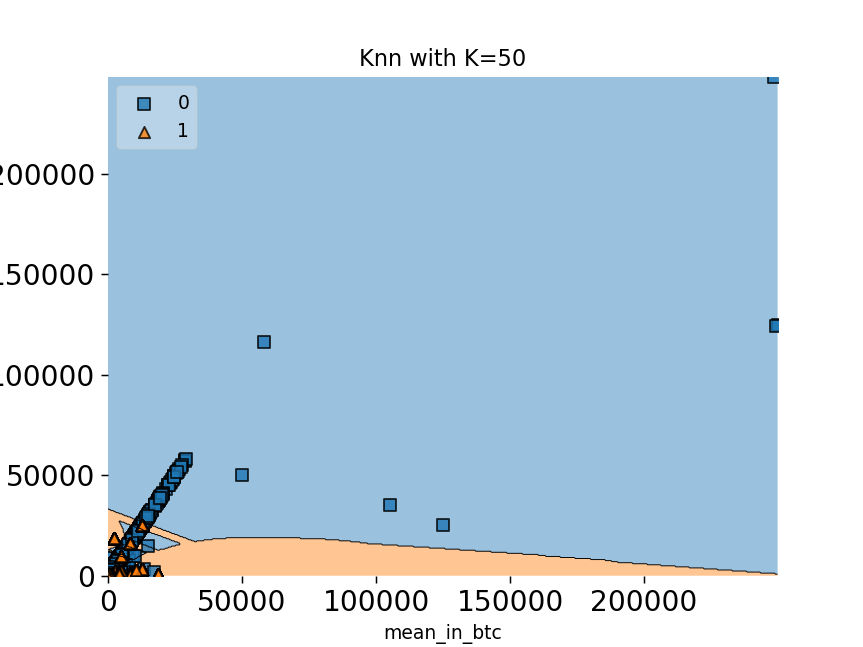

<IPython.core.display.Javascript object>


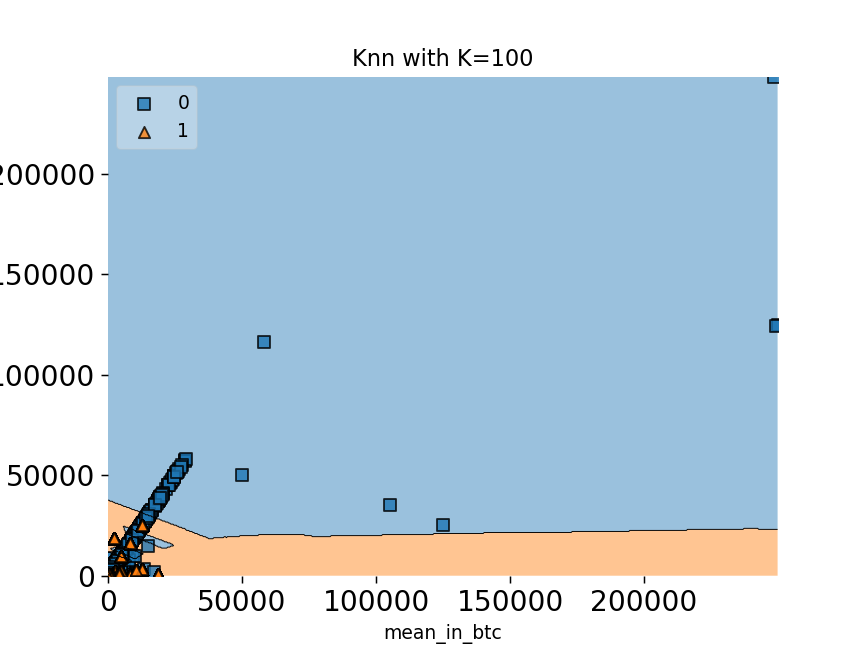

In [43]:
from mlxtend.plotting import plot_decision_regions
x = d_f.to_numpy()
y = y_train_res.to_numpy()
for i in k:
    clf = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree",n_jobs=-1)
    clf.fit(x, y)
    plt.figure()
    # Plotting decision region
    plot_decision_regions(x, y, clf=clf, legend=2)
    # Adding axes annotations
    plt.xlabel('mean_in_btc')
    plt.ylabel('mean_out_btc')
    plt.title('Knn with K='+ str(i),)
    plt.show()



In [47]:
knn=KNeighborsClassifier(n_neighbors=25,algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train_res,y_train_res.ravel())
knn_predicted_test_labels=knn.predict(X_test)
#calculating confusion matrix for knn
#scoring knn
print("K-Nearest Neighbors Algorithm")
print("Accuracy Score :")
a6=accuracy_score(y_test,knn_predicted_test_labels)
print(a6)
print("Classification Report :")
print(classification_report(y_test,knn_predicted_test_labels))
c6=classification_report(y_test,knn_predicted_test_labels, output_dict=True)

print("tn --> true negatives")
print("fp --> false positives")
print("fn --> false negatives")
print("tp --> true positives")
c=confusion_matrix(y_test,knn_predicted_test_labels)
tn,fp,fn,tp=c.ravel()
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)

K-Nearest Neighbors Algorithm
Accuracy Score :
0.9992125624632897
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   8166967
           1       0.00      0.37      0.00        30

    accuracy                           1.00   8166997
   macro avg       0.50      0.68      0.50   8166997
weighted avg       1.00      1.00      1.00   8166997

tn --> true negatives
fp --> false positives
fn --> false negatives
tp --> true positives
Confusion Matrix
tn = 8160555 fp = 6412
fn = 19 tp = 11


<IPython.core.display.Javascript object>


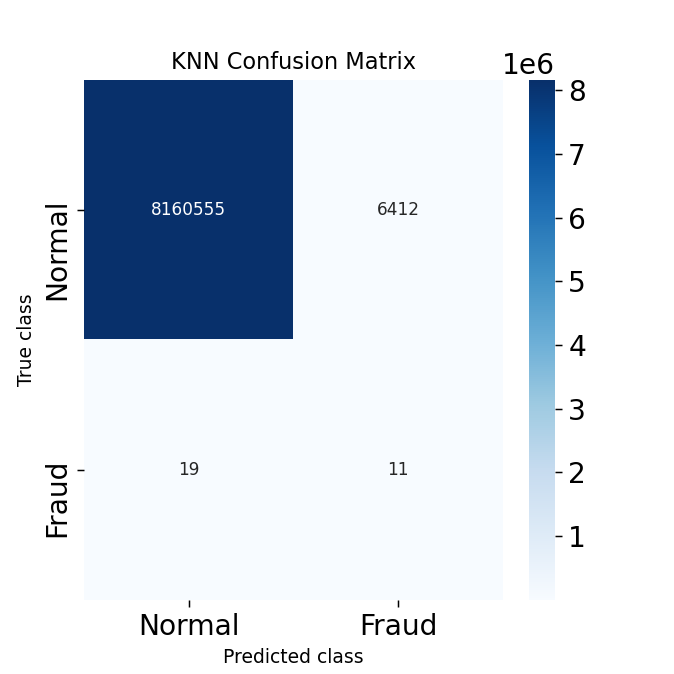

In [48]:
precision.append(round(c6['macro avg']['precision'],2))
recall.append(round(c6['macro avg']['recall'],2))
f1.append(round(c6['macro avg']['f1-score'],2))
accuracy.append(a6)
conf_matrix_percent(c,"KNN")

## Plots 

<IPython.core.display.Javascript object>


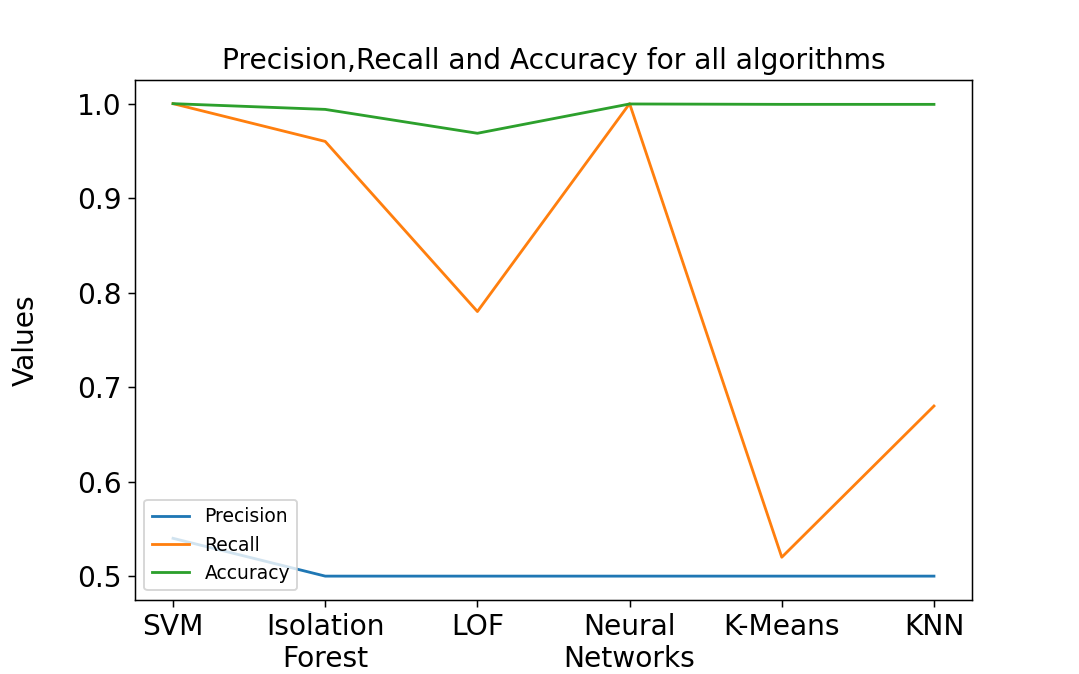

In [49]:
plt.figure(figsize=(8,5))
x=['SVM','Isolation\nForest','LOF','Neural\nNetworks','K-Means','KNN']
plt.plot(x, precision, label = "Precision")
plt.plot(x, recall, label = "Recall")
plt.plot(x, accuracy, label = "Accuracy")
plt.legend(fontsize=10,loc='lower left')
plt.xlabel('Algorithms',fontsize=15,labelpad=20)
plt.ylabel('Values',fontsize=15,labelpad=20)
plt.xticks(fontsize=15)
plt.title('Precision,Recall and Accuracy for all algorithms',fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


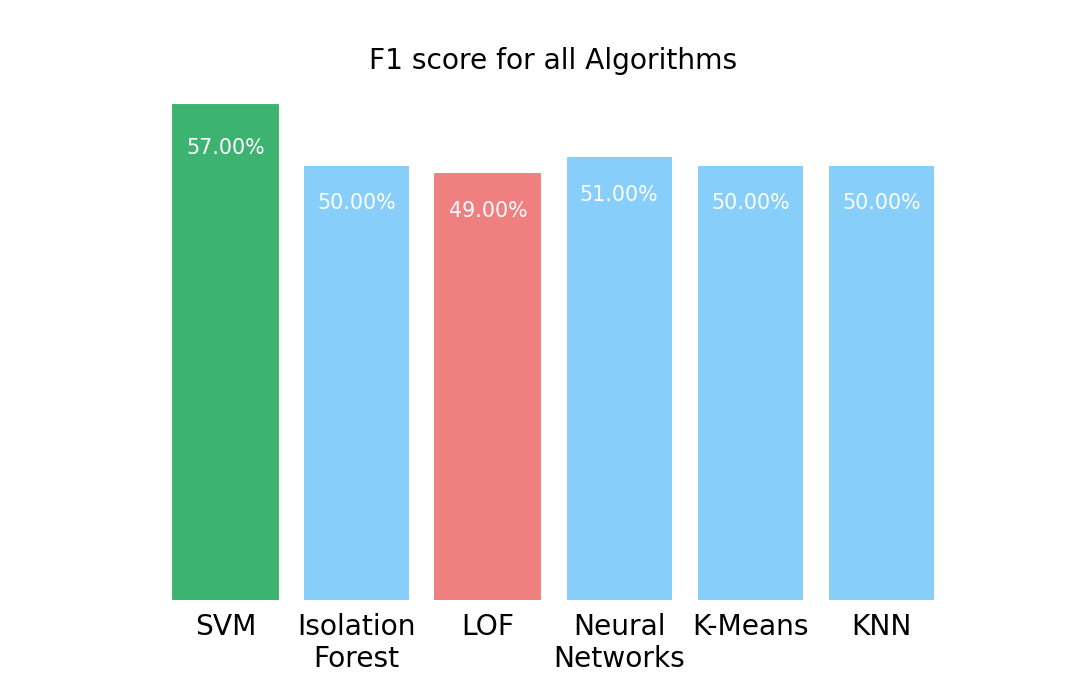

Text(0.5, 1.0, 'F1 score for all Algorithms')

In [50]:
plt.figure(figsize=(8,5))
x=['SVM','Isolation\nForest','LOF','Neural\nNetworks','K-Means','KNN']
bars = plt.bar(range(6), f1,color='lightskyblue')
# directly label the score onto the bars
for bar in bars:
    height = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width()/2, height*.90, '{0:.2f}'.format(height*100)+'%', ha='center', color='w', fontsize=11)
h=f1.index(max(f1))
l=f1.index(min(f1))
bars[h].set_color('mediumseagreen')
bars[l].set_color('lightcoral')
# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
# remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xticks([0,1,2,3,4,5],x,fontsize=15);
plt.title('F1 score for all Algorithms', fontsize=15)



